В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
# !pip install hyperopt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from pprint import pprint
from process_bank_churn import preprocess_data, preprocess_new_data

import warnings
warnings.filterwarnings("ignore")


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
raw_df=pd.read_csv('train.csv')
raw_df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
input_cols = ['id', 'CustomerId', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
target_col='Exited'
cat_cols = ['Geography', 'Gender']

train_df, val_df = split_train_val(raw_df, target_col=target_col)

train_inputs, train_targets = separate_inputs_targets(train_df, input_cols=input_cols, target_col=target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols=input_cols, target_col=target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [5]:
for col in cat_cols:
    train_inputs[col] = pd.Categorical(train_inputs[col])
    val_inputs[col] = pd.Categorical(val_inputs[col])

In [6]:
print(train_inputs.dtypes[cat_cols])

Geography    category
Gender       category
dtype: object


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [7]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',  
    # tree_method='gpu_hist',
    # device='cuda'
    enable_categorical=True,
    missing=np.nan,
    random_state=42
)

In [8]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 7180 to 9360
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               12000 non-null  int64   
 1   CustomerId       12000 non-null  float64 
 2   CreditScore      12000 non-null  float64 
 3   Geography        12000 non-null  category
 4   Gender           12000 non-null  category
 5   Age              12000 non-null  float64 
 6   Tenure           12000 non-null  float64 
 7   Balance          12000 non-null  float64 
 8   NumOfProducts    12000 non-null  float64 
 9   HasCrCard        12000 non-null  float64 
 10  IsActiveMember   12000 non-null  float64 
 11  EstimatedSalary  12000 non-null  float64 
dtypes: category(2), float64(9), int64(1)
memory usage: 1.0 MB


In [9]:
xgb_model.fit(train_inputs, train_targets)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
train_preds = xgb_model.predict_proba(train_inputs)[:, 1]
val_preds = xgb_model.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9513
Validation AUROC: 0.9364


- AUROC > 0.93 на валідації означає, що модель дуже добре навчається і передбачає.
- Модель не має високого bias, variance теж низька, бо якість на validation така сама, як на train.
- Ознак оверфіттінгу не виявлено.

- Для порівняння Decision Tree навчився ідеально на тренувальних даних (AUROC = 1.0), але працював погано на нових даних, що було ознакою оверфіттінгу.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [11]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

In [12]:
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    clf = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',  # 'gpu_hist'
        enable_categorical=True,
        **params
    )
    
    clf.fit(train_inputs, train_targets)
    val_preds = clf.predict_proba(val_inputs)[:, 1]
    val_auc = roc_auc_score(val_targets, val_preds)
    
    return {'loss': -val_auc, 'status': STATUS_OK}

In [13]:
trials = Trials()

best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|████████| 20/20 [00:03<00:00,  5.44trial/s, best loss: -0.9366973043418617]


In [14]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

pprint(best_params)

{'colsample_bytree': 0.7295996142861736,
 'gamma': 3.577792295565498,
 'learning_rate': 0.04300091748324607,
 'max_depth': 8,
 'n_estimators': 210,
 'reg_alpha': 0.8839266254726155,
 'reg_lambda': 0.620118997676641,
 'subsample': 0.9254621630561151}


In [15]:
final_clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',  # 'gpu_hist'
    enable_categorical=True,
    **best_params
)

final_clf.fit(train_inputs, train_targets)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7295996142861736, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.577792295565498, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04300091748324607,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=210, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
train_preds = final_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9523
Validation AUROC: 0.9367


- Результати нової моделі незначно, але кращі: на тренувальному AUROC 0.9523 > 0.9513, на валідаційному AUROC 0.9367 > 0.9364

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [17]:
for col in cat_cols:
    train_inputs[col] = train_inputs[col].astype('category')
    val_inputs[col] = val_inputs[col].astype('category')

In [18]:
# Індекси категоріальних колонок для LightGBM
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_cols]

In [19]:
train_data = lgb.Dataset(train_inputs, label=train_targets, categorical_feature=cat_feature_indexes, free_raw_data=False)
valid_data = lgb.Dataset(val_inputs, label=val_targets, categorical_feature=cat_feature_indexes, reference=train_data, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'seed': 42,
    'feature_pre_filter': False,
}

In [20]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    early_stopping_rounds=10,
    verbose_eval=10
)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.936659	valid_1's auc: 0.9301
[20]	training's auc: 0.943976	valid_1's auc: 0.934292
[30]	training's auc: 0.951809	valid_1's auc: 0.934763
[40]	training's auc: 0.957452	valid_1's auc: 0.9347
Early stopping, best iteration is:
[37]	training's auc: 0.955456	valid_1's auc: 0.93546


In [21]:
train_pred = model.predict(train_inputs)
val_pred = model.predict(val_inputs)

In [22]:
train_auc = roc_auc_score(train_targets, train_pred)
val_auc = roc_auc_score(val_targets, val_pred)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9555
Validation AUROC: 0.9355


- Модель має збалансовану і хорошу якість.
  
- Якщо порівняти з XGBoost (Train AUROC: 0.9523, Validation AUROC: 0.9367), модель LightGBM показує дуже близьку до XGBoost якість, різниця мінімальна.

- Різниця між train і valid AUROC: 0.9555 - 0.9355 = 0.02 — дуже маленька, отже немає ознак overfitting.

- Модель збалансована і дає хороші результати.


5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [23]:
def lgb_objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['bagging_freq'] = int(params['bagging_freq'])

    fixed_params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
    }
    all_params = {**params, **fixed_params}

    train_data = lgb.Dataset(train_inputs, label=train_targets, categorical_feature=cat_feature_indexes, free_raw_data=False)
    valid_data = lgb.Dataset(val_inputs, label=val_targets, categorical_feature=cat_feature_indexes, reference=train_data, free_raw_data=False)

    model = lgb.train(
        all_params,
        train_data,
        num_boost_round=100,
        valid_sets=[valid_data],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    val_pred = model.predict(val_inputs)
    val_auc = roc_auc_score(val_targets, val_pred)
    return {'loss': -val_auc, 'status': STATUS_OK}

In [24]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'bagging_freq': hp.quniform('bagging_freq', 1, 10, 1),
    'lambda_l1': hp.uniform('lambda_l1', 0, 5),
    'lambda_l2': hp.uniform('lambda_l2', 0, 5),
}

In [25]:
trials = Trials()
best = fmin(
    fn=lgb_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Найкращі гіперпараметри:", best)

100%|████████| 10/10 [00:00<00:00, 10.42trial/s, best loss: -0.9372230605665683]
Найкращі гіперпараметри: {'bagging_fraction': 0.7517149605448037, 'bagging_freq': 9.0, 'feature_fraction': 0.7406073781487617, 'lambda_l1': 1.7462847341763572, 'lambda_l2': 4.967030128376157, 'learning_rate': 0.17630368113106493, 'max_depth': 3.0, 'min_data_in_leaf': 41.0, 'num_leaves': 42.0}


In [26]:
best_params = {
    'learning_rate': best['learning_rate'],
    'num_leaves': int(best['num_leaves']),
    'max_depth': int(best['max_depth']),
    'min_data_in_leaf': int(best['min_data_in_leaf']),
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
}

In [27]:
train_data = lgb.Dataset(train_inputs, label=train_targets, categorical_feature=cat_feature_indexes)
valid_data = lgb.Dataset(val_inputs, label=val_targets, categorical_feature=cat_feature_indexes, reference=train_data)

final_lgb_clf = lgb.train(
    best_params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    early_stopping_rounds=10,
    verbose_eval=10
)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.926011	valid_1's auc: 0.924047
[20]	training's auc: 0.935497	valid_1's auc: 0.933993
[30]	training's auc: 0.938351	valid_1's auc: 0.937149
[40]	training's auc: 0.940072	valid_1's auc: 0.936677
Early stopping, best iteration is:
[36]	training's auc: 0.939342	valid_1's auc: 0.937223


In [28]:
train_pred_final = final_lgb_clf.predict(train_inputs)
val_pred_final = final_lgb_clf.predict(val_inputs)

train_auc_final = roc_auc_score(train_targets, train_pred_final)
val_auc_final = roc_auc_score(val_targets, val_pred_final)

print(f"Final Train AUROC: {train_auc_final:.4f}")
print(f"Final Validation AUROC: {val_auc_final:.4f}")

Final Train AUROC: 0.9393
Final Validation AUROC: 0.9372


- Train AUROC 0.9393 трохи нижче, ніж було раніше (0.9555), значить модель стала менш “перенавченою”.
- Validation AUROC 0.9372 — трохи кращий, ніж попередній (0.9355).
- Можемо зробити висновок, що тюнінг гіперпараметрів допоміг зробити модель більш збалансованою: трохи знизився overfitting, трохи покращилась узагальнююча здатність.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

Обрано останню модель LightGBM з тюнингом, бо:   
- Validation AUROC найвищий.
- Розрив train–val майже нульовий, модель дуже добре узагальнює.
- Після тюнінгу вона працює більш стабільно і впевнено, ніж дефолтні.

In [29]:
test_df = pd.read_csv('test.csv')

cols=['id', 'CustomerId', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

test_df=test_df[cols]
for col in cat_cols:
    test_df[col] = pd.Categorical(test_df[col])
test_probs = final_lgb_clf.predict(test_df)

In [30]:
test_probs = final_lgb_clf.predict(test_df[cols])

submission_df = pd.read_csv("sample_submission.csv")
submission_df['Exited'] = test_probs
submission_df.to_csv("submission_lgb_final.csv", index=False)
print("Submission saved.")

Submission saved.


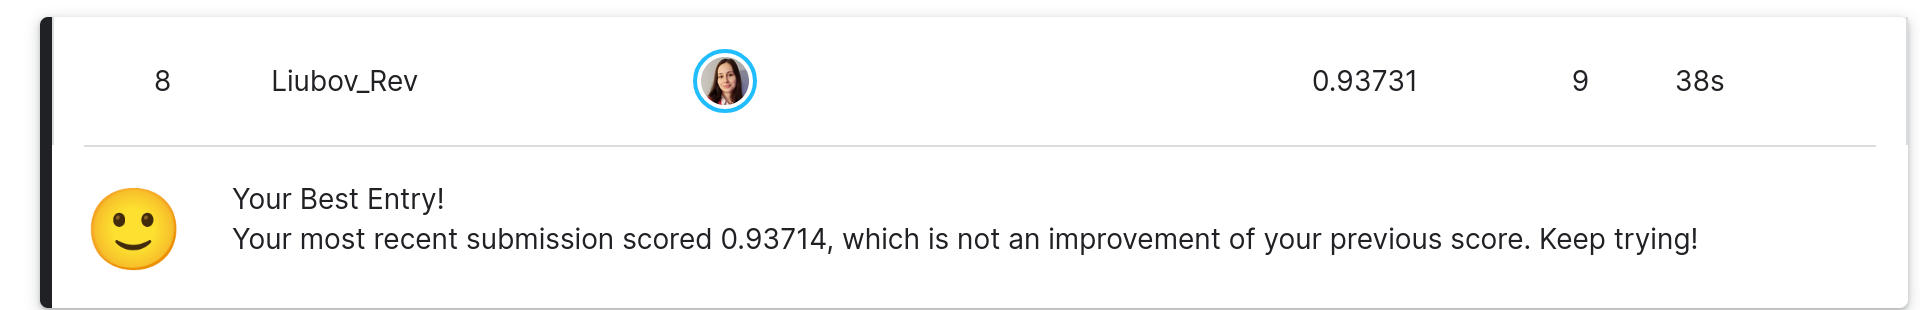